In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
import seaborn as sns
sns.set_style("white")

In [2]:
#Always call fit on the estimator before invoking this method. 
def importances(model, col_array, title): 
    # Calculate the feature ranking - Top 10 
    importances = model.feature_importances_ 
    indices = np.argsort(importances)[::-1]
    print("Top Important Features\n", title)
    #for f in range(col_array.shape[1]-1): 
    for f in range(10): 
        print("%d. %s (%f)" % (f + 1, col_array.columns[indices[f]], importances[indices[f]]))
        
    #Mean Feature Importance 
    print("\nMean Feature Importance ", np.mean(importances))
    #Plot the feature importances of the forest 
    indices=indices[:10]
    plt.figure()
    plt.title(title+" Top 10 Feature importances")
    plt.bar(range(10), importances[indices], color="gr", align="center")
    plt.xticks(range(10), col_array.columns[indices], fontsize=8, rotation=90)
    plt.xlim([-1, 10])
    plt.show()

In [3]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

### Load train and test data

In [4]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

In [6]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [7]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [8]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [9]:
len(listOfBs)

259

In [19]:
# Add Latitude and Longitude to the initial dataset
df_mess_pos = df_mess_train.copy()
df_mess_pos[['lat', 'lng']] = pos_train
df_mess_pos.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940


### Load splitted data from CSV

In [20]:
# Load data
my_train_file = 'my_train_merged.csv'
df_train_merged = pd.read_csv(my_train_file, sep = ',')
my_test_file = 'my_test_merged.csv'
df_test_merged = pd.read_csv(my_test_file, sep = ',')

### Count messages

**Validation train**

In [18]:
# Count how many times a message appears in the dataset
df_count_messid_merge_train = df_train_merged.groupby(['messid'], as_index=False)['lat'].count()
df_count_messid_merge_train.columns = ['messid', 'count']
df_count_messid_merge_train.sort_values(by='count', ascending=False).head()

,messid,count
1471,57aeb41fe541cd77a044cdb8,106
4066,583c50decf554f7e3a360e58,81
1303,57a55f8acf554f465affb243,66
666,576a5337e541cd6a410a97e2,64
1302,57a55db1cf554f465afeb2e3,61


**Validation Test**

In [23]:
# Count how many times a message appears in the dataset
df_count_messid_merge_test = df_test_merged.groupby(['messid'], as_index=False)['lat'].count()
df_count_messid_merge_test.columns = ['messid', 'count']
df_count_messid_merge_test.sort_values(by='count', ascending=False).head()

,messid,count
1493,582c996c12f1434b9c20a854,80
1492,582c96ffcf554f7e3ab32732,80
1490,582c922212f1434b9c1aec97,77
1442,5829610d12f1434b9ca6ba9a,75
1457,582c212d12f1434b9cb883a7,73


**Initial Train**

In [21]:
# Count how many times a message appears in the dataset
df_count_messid = df_mess_pos.groupby(['messid'], as_index=False)['lat'].count()
df_count_messid.columns = ['messid', 'count']
df_count_messid.sort_values(by='count', ascending=False).head()

,messid,count
2261,57aeb41fe541cd77a044cdb8,106
5632,583c50decf554f7e3a360e58,81
5218,582c996c12f1434b9c20a854,80
5217,582c96ffcf554f7e3ab32732,80
5215,582c922212f1434b9c1aec97,77


**Initial Test**

In [22]:
# Count how many times a message appears in the dataset
df_count_messid_test = df_mess_test.groupby(['messid'], as_index=False)['did'].count()
df_count_messid_test.columns = ['messid', 'count']
df_count_messid_test.sort_values(by='count', ascending=False).head()

,messid,count
4216,580f7496e541cd2ed5909472,64
959,576791c2f0fe6e0c9f1f3022,51
1973,57a461cbe541cd77a0a08383,51
2833,57d647ab12f14375316783c1,50
1721,5790830dcf554f22c12e2c3b,49


### Features transformation

**Transform time units**

In [24]:
# Transform time units
df_train_merged['time_ux'] = df_train_merged['time_ux'] / 10**9
df_test_merged['time_ux'] = df_test_merged['time_ux'] / 10**9
df_mess_pos['time_ux'] = df_mess_pos['time_ux'] / 10**9
df_mess_test['time_ux'] = df_mess_test['time_ux'] / 10**9

**Add distance to the station for information**

In [26]:
# Add distance to the station for information
station_dist = vincenty_vec(df_mess_pos[['bs_lat', 'bs_lng', 'lat', 'lng']].values)
df_mess_pos['station_dist'] = np.asarray(station_dist)

In [27]:
df_mess_pos.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,station_dist
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1463.546329,39.617794,-104.954917,39.606690,-104.958490,1270.477542
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1463.546329,39.677251,-104.952721,39.606690,-104.958490,7849.923666
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1463.546707,39.612745,-105.008827,39.637741,-104.958554,5131.577744
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1463.553232,39.797969,-105.073460,39.730417,-104.968940,11681.758740
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1463.553232,39.723151,-104.956216,39.730417,-104.968940,1356.862195


Look like the rssi column indicates which station is closest 

**Correct the stations localizations**

**Initial Train**

In [29]:
outliers_bsid = np.unique(df_mess_pos[df_mess_pos['bs_lat'] >= 50]['bsid'])
print(outliers_bsid.shape[0], "stations are ouliers:\n", outliers_bsid)

27 stations are ouliers:
 [ 1092  1594  1661  1743  1772  1796  1854  2293  2707  2943  4123  4129
  4156  4959  4987  4993  7248  8355  8449  8451  8560  9784 10151 10162
 10999 11007 11951]


In [30]:
# Calculate the stations latitude and longitude means without the outliers
bs_lat_mean = np.mean(df_mess_pos[df_mess_pos['bs_lat'] <= 50]['bs_lat'])
bs_lng_mean = np.mean(df_mess_pos[df_mess_pos['bs_lng'] <= -90]['bs_lng'])
print("Station Latitude Mean:", bs_lat_mean)
print("Station Longitude Mean:", bs_lng_mean)

Station Latitude Mean: 39.8173020883778
Station Longitude Mean: -105.05761880855087


In [31]:
df_mess_pos[df_mess_pos['bs_lat'] >= 50].head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng,lat,lng,station_dist
5106,57617e1ef0fe6e0c9fd6eb06,8355,476606.0,1.5,-106.5,1466.007070,64.3,-68.5,39.778694,-104.977050,3.606569e+06
5118,576180cf3e952e04b3b41e5c,8355,476512.0,0.5,-111.5,1466.007759,64.3,-68.5,39.783396,-104.999821,3.607053e+06
5179,5761a161f0fe6e0c9fec42b9,8355,473683.0,0.0,-126.0,1466.016097,64.3,-68.5,39.803407,-105.019300,3.605912e+06
5216,57623817864fce5689ec33af,8355,473683.0,0.5,-127.0,1466.054679,64.3,-68.5,39.803738,-105.018997,3.605868e+06
5416,5763734c864fce5689a422f3,8355,476600.0,1.5,-123.0,1466.135372,64.3,-68.5,39.803101,-105.023292,3.606107e+06


**Initial Test**

In [32]:
outliers_bsid_test = np.unique(df_mess_test[df_mess_test['bs_lat'] >= 50]['bsid'])
# np.unique(df_mess_pos[df_mess_pos['bs_lng'] >= -90]['bsid'])
print(outliers_bsid_test.shape[0], "stations are ouliers:\n", outliers_bsid_test)

23 stations are ouliers:
 [ 1092  1594  1661  1743  1772  1796  1854  2707  2943  4129  4156  4987
  4993  7248  8355  8449  8451  8560  9941  9949 10151 10162 11007]


Almost the same stations are outliers in both train and test sets. 
In the test dataset only the following two stations 9941, 9949 have bad coordonates.

In [33]:
# Calculate the stations latitude and longitude means without the outliers
bs_lat_mean_test = np.mean(df_mess_test[df_mess_test['bs_lat'] <= 50]['bs_lat'])
bs_lng_mean_test = np.mean(df_mess_test[df_mess_test['bs_lng'] <= -90]['bs_lng'])
print("Station Latitude Mean:", bs_lat_mean_test)
print("Station Longitude Mean:", bs_lng_mean_test)

Station Latitude Mean: 39.7614199213808
Station Longitude Mean: -105.06017934304562


For each station we need to set the bs_lat equal to mean(lat) for all the associated messages.
However because we do not have the lat and lng columns in test set we will use the same rule in both datasets:
- set the bs_lat and bs_lng to the mean value of all normal entries

In [34]:
df_mess_pos_test = df_mess_test.copy()

In [35]:
df_mess_pos['bs_lat'].loc[df_mess_pos['bs_lat'] >= 50] = (bs_lat_mean + bs_lat_mean_test)/2
df_mess_pos_test['bs_lat'].loc[df_mess_pos_test['bs_lat'] >= 50] = (bs_lat_mean + bs_lat_mean_test)/2

df_mess_pos['bs_lng'].loc[df_mess_pos['bs_lng'] >= -90] = (bs_lng_mean + bs_lng_mean_test)/2
df_mess_pos_test['bs_lng'].loc[df_mess_pos_test['bs_lng'] >= -90] = (bs_lng_mean + bs_lng_mean_test)/2

In [36]:
df_mess_pos[df_mess_pos['bs_lat'] >= 50].shape

(0, 11)

**Validation train**

In [37]:
df_train_merged['bs_lat'].loc[df_train_merged['bs_lat'] >= 50] = (bs_lat_mean + bs_lat_mean_test)/2
df_test_merged['bs_lat'].loc[df_test_merged['bs_lat'] >= 50] = (bs_lat_mean + bs_lat_mean_test)/2

df_train_merged['bs_lng'].loc[df_train_merged['bs_lng'] >= -90] = (bs_lng_mean + bs_lng_mean_test)/2
df_test_merged['bs_lng'].loc[df_test_merged['bs_lng'] >= -90] = (bs_lng_mean + bs_lng_mean_test)/2

In [38]:
df_train_merged[df_train_merged['bs_lat'] >= 50].shape

(0, 10)

### Feature Matrix construction

In [39]:
lat_listOfBs = ['lat_' + s for s in list(listOfBs.astype(str))]
lng_listOfBs = ['lng_' + s for s in list(listOfBs.astype(str))]
nseq_listOfBs = ['nseq_' + s for s in list(listOfBs.astype(str))]
feature_cols = list(listOfBs.astype(str)) + lat_listOfBs + lng_listOfBs + nseq_listOfBs

In [40]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(feature_cols))), columns = feature_cols) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:        
        df_mess_bs_group.get_group(key)
        bsid_list = df_mess_bs_group.get_group(key)['bsid'].astype(str)
        lat_bsid_list = ['lat_' + s for s in list(bsid_list.astype(str))]
        lng_bsid_list = ['lng_' + s for s in list(bsid_list.astype(str))]
        nseq_bsid_list = ['nseq_' + s for s in list(bsid_list.astype(str))]
        rssi_list = df_mess_bs_group.get_group(key)['rssi']
        bs_lat_list = df_mess_bs_group.get_group(key)['bs_lat']
        bs_lng_list = df_mess_bs_group.get_group(key)['bs_lng']
        nseq_list = df_mess_bs_group.get_group(key)['nseq']
        df_feat.loc[idx, bsid_list] = rssi_list.values
        df_feat.loc[idx, lat_bsid_list] = bs_lat_list.values
        df_feat.loc[idx, lng_bsid_list] = bs_lng_list.values
        df_feat.loc[idx, nseq_bsid_list] = nseq_list.values
        id_list[idx] = key
        idx = idx + 1
    
    #df_feat['count'] = df_count_messid['count']
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [41]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [42]:
# Generate train features matrix
df_feat, id_list_train = feat_mat_const(df_train_merged, listOfBs)
df_feat.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,nseq_9936,nseq_9941,nseq_9949,nseq_10134,nseq_10148,nseq_10151,nseq_10162,nseq_10999,nseq_11007,nseq_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
df_feat.shape

(4418, 1036)

In [44]:
new_pos_train = df_train_merged[['lat', 'lng']]
gr_truth_lat_train, gr_truth_lng_train = ground_truth_const(df_train_merged, new_pos_train)
gr_truth_lat_train.shape

(4418,)

In [45]:
new_pos_test = df_test_merged[['lat', 'lng']]
gr_truth_lat_test, gr_truth_lng_test = ground_truth_const(df_test_merged, new_pos_test)
gr_truth_lat_test.shape

(1650,)

In [46]:
# Generate test features matrix
df_feat_test, id_list_test = feat_mat_const(df_test_merged, listOfBs)
df_feat_test.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,nseq_9936,nseq_9941,nseq_9949,nseq_10134,nseq_10148,nseq_10151,nseq_10162,nseq_10999,nseq_11007,nseq_11951
0,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model and Prediction

In [54]:
def regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, df_test, gr_truth_lat_test, gr_truth_lng_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model

    X_train = np.array(df_feat);
    X_test = np.array(df_test);
    #reg = linear_model.LinearRegression()
    #reg = RandomForestRegressor(random_state=2792)
    reg = ExtraTreesRegressor()

    reg.fit(X_train, gr_truth_lat_train);
    y_pred_lat = reg.predict(df_test) 
    print("Latitude Accuracy :", reg.score(X_test, gr_truth_lat_test))
    importances(reg, df_feat, "Latitude Features utilisée")

    reg.fit(X_train, gr_truth_lng_train);
    y_pred_lng = reg.predict(df_test) 
    print("Longitude Accuracy :", reg.score(X_test, gr_truth_lng_test))
    importances(reg, df_feat, "Longitude Features utilisée")
    
    return y_pred_lat, y_pred_lng


**Make regressor and prediction using the validation test set**

Latitude Accuracy : 0.3039092209202823
Top Important Features
 Latitude Features utilisée
1. lat_4790 (0.309770)
2. lng_4790 (0.247816)
3. 4790 (0.062332)
4. lng_3613 (0.051299)
5. lat_1828 (0.030423)
6. lat_7490 (0.026462)
7. 3613 (0.022176)
8. lng_3629 (0.014685)
9. lng_7807 (0.014096)
10. lat_1526 (0.013231)

Mean Feature Importance  0.0009652509652509652


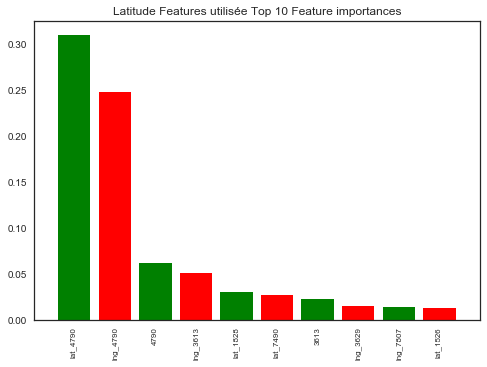

Longitude Accuracy : 0.30941436298189795
Top Important Features
 Longitude Features utilisée
1. lat_4790 (0.448766)
2. lng_4790 (0.128219)
3. 4790 (0.064782)
4. lat_3613 (0.059035)
5. lng_1828 (0.033848)
6. 1828 (0.022565)
7. lat_7490 (0.021689)
8. lng_3613 (0.014765)
9. nseq_1534 (0.014422)
10. lat_3629 (0.012085)

Mean Feature Importance  0.0009652509652509653


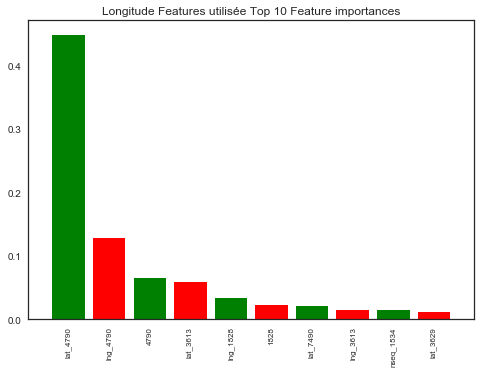

In [55]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, gr_truth_lat_train, gr_truth_lng_train, 
                                               df_feat_test, gr_truth_lat_test, gr_truth_lng_test)

### Cross validation

In [121]:
from sklearn.model_selection import cross_val_predict

In [122]:
reg_cv = RandomForestRegressor()
y_pred_cv_lng = cross_val_predict(reg_cv, df_feat, ground_truth_lng, cv=10)
y_pred_cv_lat = cross_val_predict(reg_cv, df_feat, ground_truth_lat, cv=10)

### Evaluate result

In [50]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

**Errors calculation**

In [56]:
err_vec = Eval_geoloc(gr_truth_lat_test , gr_truth_lng_test, y_pred_lat, y_pred_lng)

In [123]:
err_vec_cv = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_cv_lat, y_pred_cv_lng)

In [22]:
# Plot error distribution

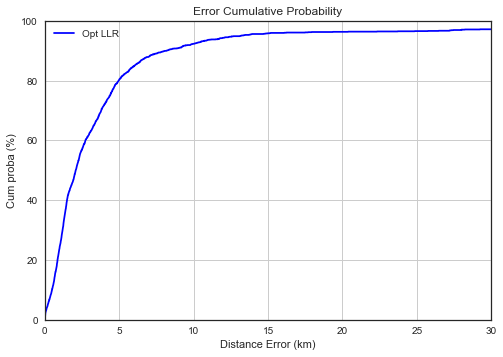

In [57]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [58]:
# Error criterion
np.percentile(err_vec, 80)

4972.337580281492

In [124]:
# Error criterion CV
np.percentile(err_vec_cv, 80)

3928.0020347757454

In [25]:
# Construct test prediction

In [26]:
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [27]:
df_feat_test, id_list_test = feat_mat_const(df_mess_test, listOfBs)

In [28]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)

In [29]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = id_list_test

In [31]:
test_res.to_csv('pred_pos_test_list.csv', index=False)

In [32]:
test_res.head()

,lat,lng,messid
0,39.772618,-105.050029,573be2503e952e191262c351
1,39.775792,-105.063594,573c05f83e952e1912758013
2,39.678112,-105.012249,573c0796f0fe6e735a66deb3
3,39.773777,-105.037761,573c08d2864fce1a9a0563bc
4,39.678112,-105.012249,573c08ff864fce1a9a0579b0
